# Generalized for more standard stars

In [23]:
import os
os.environ["PYSYN_CDBS"] 
from os import listdir 
import numpy as np
import synphot as S
from synphot import  SourceSpectrum
from synphot.models import BlackBodyNorm1D
from synphot import SpectralElement, Observation, units
from synphot.models import Empirical1D
import astropy.units as u
from synphot import Observation, units
from matplotlib import pyplot as plt
import matplotlib 
import pandas as pd

from pprint import pprint 


import warnings

from astropy.io import fits

import importlib

plt.rcParams["figure.figsize"] = (20,5)


#vega_file = os.path.join(os.environ['PYSYN_CDBS'], 'calspec', 'alpha_lyr_stis_005.fits')

In [24]:
import synphot_routines as SYNR

# Telescope Parameters

In [25]:

area=50*1E4*units.AREA
area


<Quantity 500000. cm2>

# Load files of SCORPIO Throughputs

In [26]:

filters_directory = os.getcwd()+"/scorpio_throughputs"
files_dir=os.listdir(filters_directory)
filter_file=[]
filters=[]
for names in files_dir:
    if names.endswith("txt"):
        filter_file.append(names)
        names = names[:-4]        #remove .txt to get the filter names
        
        filters.append(names)
    
print(filter_file,'\n\n',filters)

['SCORPIO_r.txt', 'SCORPIO_g.txt', 'SCORPIO_J_no_adc.txt', 'SCORPIO_g_no_adc.txt', 'SCORPIO_Y_no_adc.txt', 'SCORPIO_H_no_adc.txt', 'SCORPIO_K_no_adc.txt', 'SCORPIO_z.txt', 'SCORPIO_i_no_adc.txt', 'SCORPIO_z_no_adc.txt', 'SCORPIO_Y.txt', 'SCORPIO_J.txt', 'SCORPIO_K.txt', 'SCORPIO_i.txt', 'SCORPIO_r_no_adc.txt', 'SCORPIO_H.txt'] 

 ['SCORPIO_r', 'SCORPIO_g', 'SCORPIO_J_no_adc', 'SCORPIO_g_no_adc', 'SCORPIO_Y_no_adc', 'SCORPIO_H_no_adc', 'SCORPIO_K_no_adc', 'SCORPIO_z', 'SCORPIO_i_no_adc', 'SCORPIO_z_no_adc', 'SCORPIO_Y', 'SCORPIO_J', 'SCORPIO_K', 'SCORPIO_i', 'SCORPIO_r_no_adc', 'SCORPIO_H']


# Vega 

from the original file
1774.7418447472853 PHOTLAM


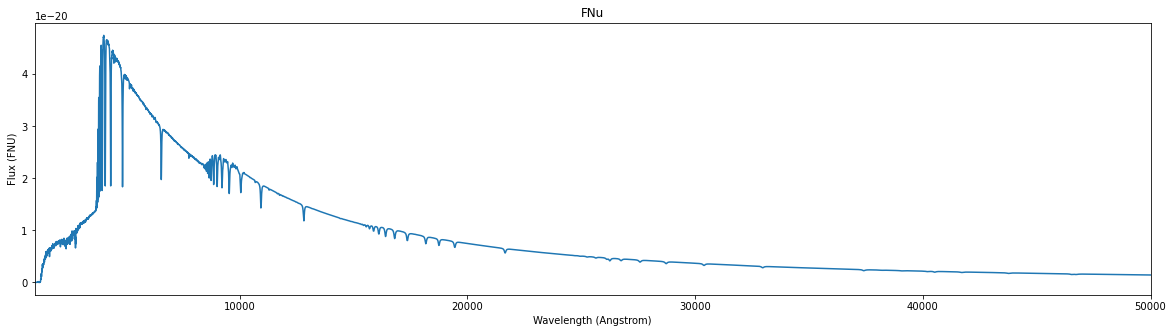

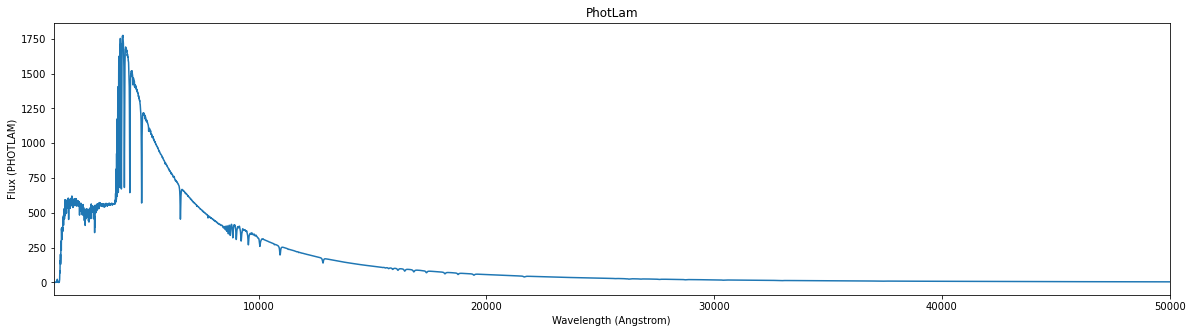

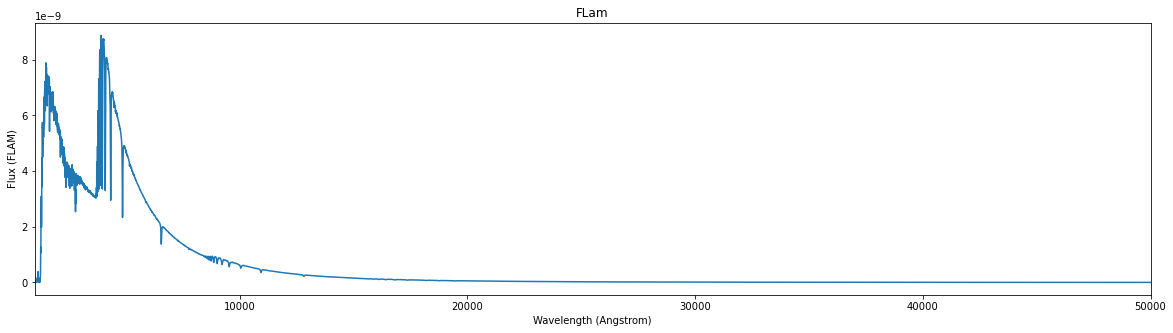

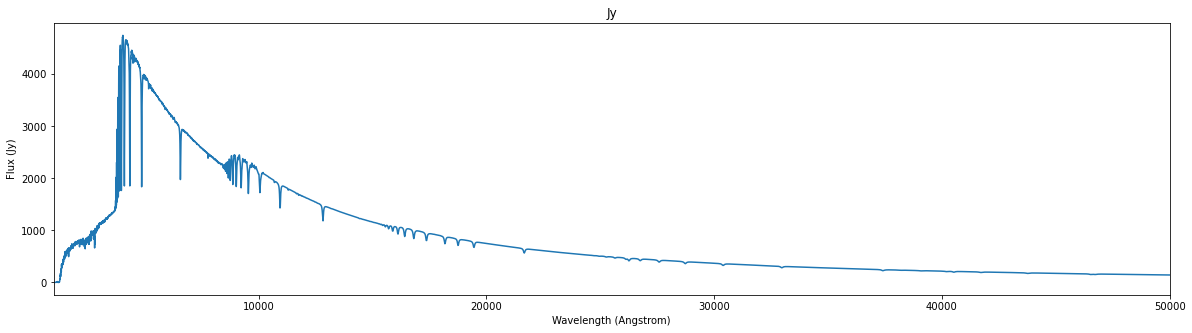

In [27]:
#read STSDAS vega spectrum

vega = SourceSpectrum.from_vega()
# this is a "SourceSpectrum", synphot object, with units
# in photlam, the default for SourceSpectrum

print("from the original file")
print(max(vega(vega.waveset)))
#Plot using the SourceSpectrum.plot method, but specifying different 
vega.plot(left=1000,right=50000,flux_unit='fnu',title='FNu')
vega.plot(left=1000,right=50000,flux_unit='photlam',title='PhotLam')
vega.plot(left=1000,right=50000,flux_unit='flam',title='FLam')
vega.plot(left=1000,right=50000,flux_unit='Jy',title='Jy')#you can see this is a FNu type of unit

In [28]:
#How to convert units
#First, convert the flux *arrays* from photlam to fnu, flam, fJy
vega_fnu=units.convert_flux(vega.waveset,fluxes=vega(vega.waveset),out_flux_unit = units.FNU)
vega_flam=units.convert_flux(vega.waveset,fluxes=vega(vega.waveset),out_flux_unit = units.FLAM)
vega_Jy=units.convert_flux(vega.waveset,fluxes=vega(vega.waveset),out_flux_unit = u.Jy)
                           
#check:
print("\n from converted fluxes")
print(max(vega_fnu))
print(max(vega_flam))
print(max(vega_Jy))
#ok
                           
#then rebuild the spectra with these these values
vega_fnu=SourceSpectrum(Empirical1D,points=vega.waveset,lookup_table=vega_fnu)
vega_flam=SourceSpectrum(Empirical1D,points=vega.waveset,lookup_table=vega_flam)
vega_Jy=SourceSpectrum(Empirical1D,points=vega.waveset,lookup_table=vega_Jy)
                       
# finally create synphot spectra that have the right flux units.
vega_fnu=vega_fnu(vega.waveset,flux_unit=units.FNU)
vega_flam=vega_flam(vega.waveset,flux_unit=units.FLAM)
vega_Jy=vega_Jy(vega.waveset,flux_unit=u.Jy)
#check:
print("\n from the rebuilt spectra")
print(max(vega_fnu))
print(max(vega_flam))
print(max(vega_Jy))


 from converted fluxes
4.747549860060794e-20 FNU
8.871499979079545e-09 FLAM
4747.549860060793 Jy

 from the rebuilt spectra
4.747549860060794e-20 FNU
8.871499979079545e-09 FLAM
4747.549860060793 Jy


# The get_synphot_table routine

This routine builds spectra for each of the filters and returns a table with the following columns:

<b>Filter name</b> : names with "_no_adc" refer to throughputs with no atmosheric correction <br>
<b>Counts/s</b> :  predicted count rate for the telescope area through the given filter<br>
<b>VegaMag</b> :   predicted Vega magnitude through the given filter (Vega spectrum is in ABmag units<br>
<b>pivot_w</b>l :  pivot wavelength to allow exact conversion between flux densities $F_{\nu}(R)$ and $F_{\lambda}(R)$ (source-independent)<br>
<b>effective_wl</b> :  effective wavelength or the mean wavelength of detected photons (source-dependent)


### $\mathrm{vegamag} = -2.5 \mathrm{log_{10}} \frac{f}{f(VEGA)}$ 

### $\mathrm{ABmag} = -2.5 \mathrm{log_{10}} \frac{f_{\nu}}{3631 \ \mathrm{Jy}} $, unit is FNU



The second item returned is a dictionary where each filter containing the newly built spectra of the standard star.

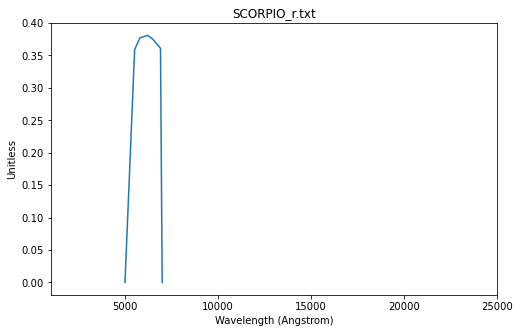

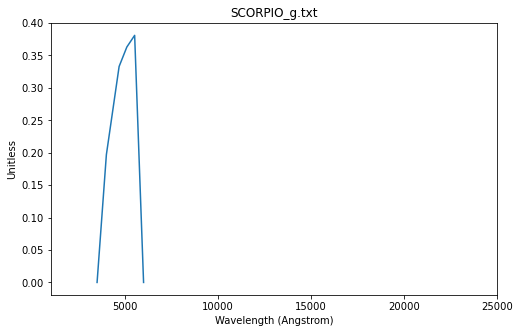

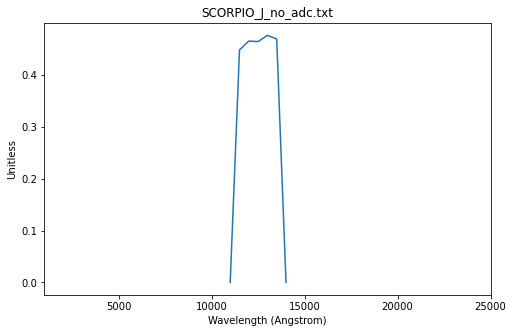

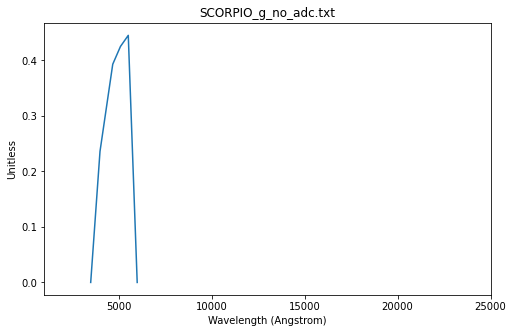

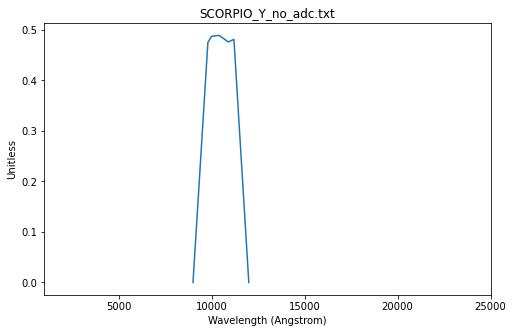

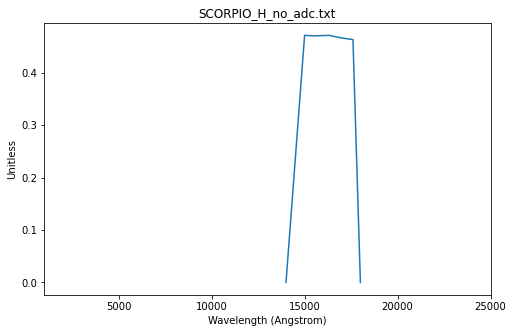

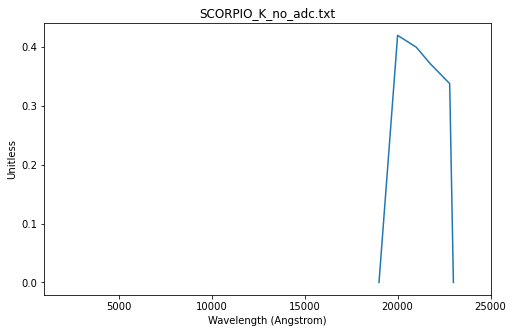

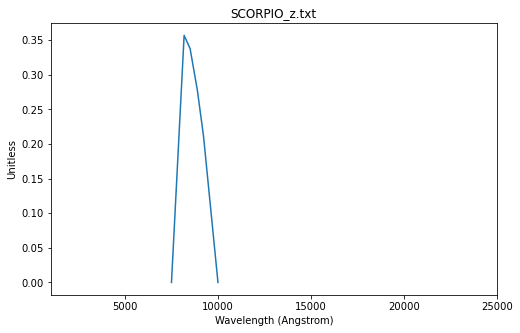

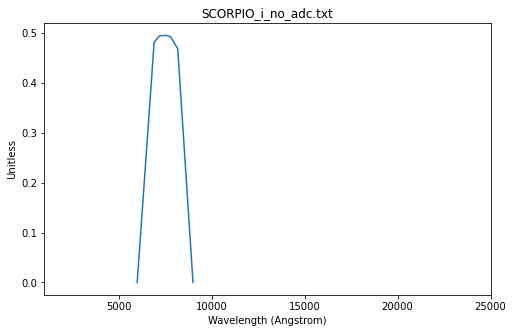

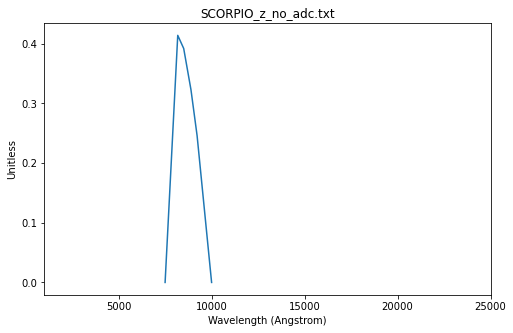

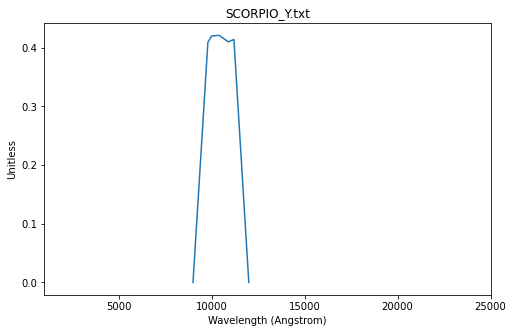

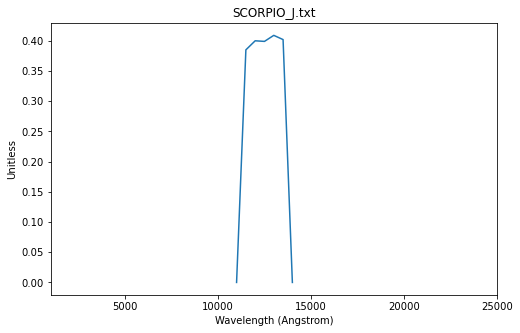

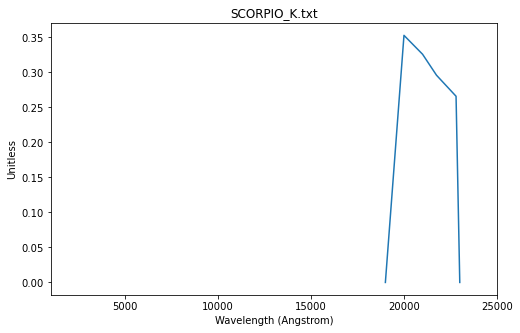

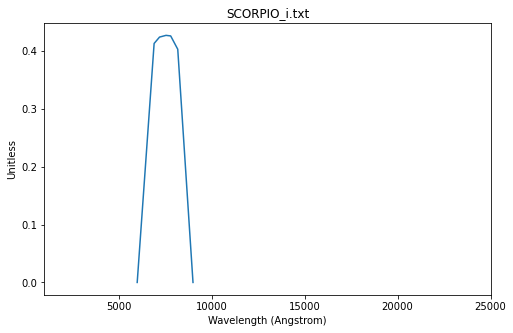

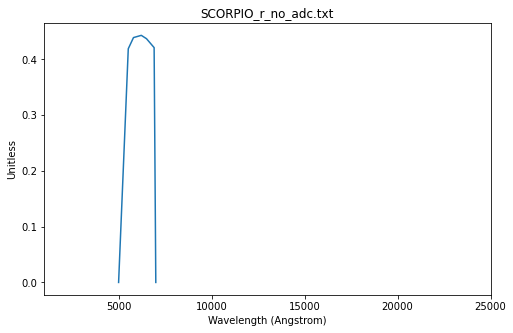

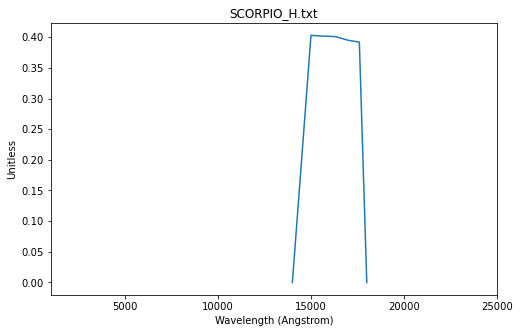

In [29]:
importlib.reload(SYNR)

obs_vega_Filter_table, vega_ObsDict = SYNR.get_vega_synphot_table(filters=filters,filter_file=filter_file,
                                                    filters_dir=filters_directory,
                                                    vega=vega,area=area,filter_plot=True)


In [30]:
obs_vega_Filter_table

,Filter,Counts_s-1,VegaMag,pivot_wl,effective_wl
0,SCORPIO_g_no_adc,438471030701.8 ct,-0.055 mag(AB),4772.7 Angstrom,4804.65 Angstrom
1,SCORPIO_g,371893012680.96 ct,-0.055 mag(AB),4777.22 Angstrom,4809.11 Angstrom
2,SCORPIO_r_no_adc,296713259726.82 ct,0.113 mag(AB),5995.51 Angstrom,6016.03 Angstrom
3,SCORPIO_r,254643165470.47 ct,0.113 mag(AB),5995.76 Angstrom,6016.26 Angstrom
4,SCORPIO_i_no_adc,272095506644.56 ct,0.354 mag(AB),7364.17 Angstrom,7393.45 Angstrom
5,SCORPIO_i,234176632269.55 ct,0.354 mag(AB),7365.34 Angstrom,7394.61 Angstrom
6,SCORPIO_z,104000313130.2 ct,0.496 mag(AB),8559.84 Angstrom,8576.24 Angstrom
7,SCORPIO_z_no_adc,120665453724.24 ct,0.496 mag(AB),8560.04 Angstrom,8576.44 Angstrom
8,SCORPIO_Y,130768057412.98 ct,0.653 mag(AB),10379.77 Angstrom,10401.27 Angstrom
9,SCORPIO_Y_no_adc,151842533875.09 ct,0.653 mag(AB),10379.9 Angstrom,10401.4 Angstrom


# Getting XSHOOTER spectra


I downloaded XSHOOTER spectra from ESO data archive.

The way the original data BinTables are formatted is a little weird and can't be read by synphot initially, so I deconstructed the data and created new BinTable files.  Original file names start with `ADP`, new file names are formatted as `[targname]_[vis/nir/mod]_spec.fits`.




# XSHOOTER Stars


<a href="http://www.eso.org/rm/api/v1/public/releaseDescriptions/70">XSHOOTER spectral library data description.</a>

Model spectra for the standards are from <a href="https://ui.adsabs.harvard.edu/abs/2014A%26A...568A...9M/abstract">Moehler et al. (2014)</a>.  The wavelength coverage for these stars ($\lambda \ \simeq$ 4000-2000 <span>&#8491;</span>) is similar to SCORPIO's coverage.

Name&ensp;&ensp;&emsp;A8 &ensp;&ensp;&emsp;--- &emsp;&emsp;&ensp;&emsp; Star name <br>
RAh&ensp;&ensp;&emsp;&emsp;I2 &ensp;&ensp;&emsp;&ensp; h &emsp;&emsp;&emsp;&emsp; Right Ascension J2000 (hours) <br>
RAm&ensp;&emsp;&emsp;I2 &ensp;&emsp;&ensp; min&emsp;&emsp;&emsp;&ensp; Right Ascension J2000 (minutes) <br>
RAs&emsp;&emsp;&nbsp; F5.2 &ensp;&emsp; s&emsp;&emsp;&emsp;&nbsp;&nbsp; Right Ascension J2000 (seconds) <br>
DE-&emsp;&emsp;&nbsp;&nbsp;A1 &emsp;&ensp;&ensp; ---&emsp;&emsp;&emsp; &ensp; Declination J2000 (sign) <br>
DEd &ensp;&ensp;&ensp;&emsp; I2 &emsp;&ensp;&nbsp; deg&ensp;&ensp;&emsp;&ensp;&emsp;&ensp; Declination J2000 (degrees) <br>
DEm&ensp;&emsp;&emsp;I2 &emsp;&ensp;&nbsp; arcmin&emsp;&ensp;&nbsp; Declination J2000 (minutes) <br>
DEs &emsp;&ensp;&ensp;&nbsp; F4.1 &nbsp; arcsec&emsp;&ensp;&nbsp; Declination J2000 (seconds) <br>
Teff&emsp;&emsp;&emsp;I5 &ensp;&emsp;&nbsp; K &emsp;&emsp;&emsp;&emsp; [8081/45250] Effective temperature <br>
log g&emsp;&emsp;F4.2&nbsp;&nbsp;&nbsp;[cm/s2]  &emsp; [5.8/8.2] Surface gravity <br>
SpT&emsp;&nbsp;&emsp;&ensp;A3 &ensp;&nbsp;&nbsp; ---&emsp;&emsp;&emsp;&emsp; Spectral type <br>

            
            
         
<table>
  <tr>
    <th>Name</th>
    <th>RAh</th> 
    <th>RAm</th>
    <th>RAs</th>
    <th>DEd</th>
    <th>DEm</th>
    <th>DEs</th>
    <th>Teff</th>
    <th>log g</th>
    <th>SpT</th>
  </tr>
  <tr>
    <td>GD71</td>
    <td>05</td> 
    <td>52</td>
    <td>27.61</td>
    <td>+15</td>
    <td>53</td>
    <td>13.8</td>
    <td>33590</td>
    <td>7.93</td>
    <td>DA</td>
  </tr>
  <tr>
    <td>LTT3218</td>
    <td>08</td> 
    <td>41</td>
    <td>32.50</td>
    <td>-32</td>
    <td>56</td>
    <td>34.0</td>
    <td>9081</td>
    <td>7.71</td>
    <td>DA</td>
  </tr>
  <tr>
    <td>GD153</td>
    <td>12</td> 
    <td>57</td>
    <td>02.34</td>
    <td>+22</td>
    <td>01</td>
    <td>52.7</td>
    <td>40320</td>
    <td>7.93</td>
    <td>DA</td>
  </tr>
  <tr>
    <td>EG274</td>
    <td>16</td> 
    <td>23</td>
    <td>33.84</td>
    <td>-39</td>
    <td>13</td>
    <td>46.2</td>
    <td>25985</td>
    <td>7.96</td>
    <td>DA</td>
  </tr>
  <tr>
    <td>LTT7987</td>
    <td>20</td> 
    <td>10</td>
    <td>56.85</td>
    <td>-30</td>
    <td>13</td>
    <td>06.6</td>
    <td>16147</td>
    <td>7.98</td>
    <td>DA</td>
  </tr>
  <tr>
    <td>Feige110</td>
    <td>23</td> 
    <td>19</td>
    <td>58.40</td>
    <td>-05</td>
    <td>09</td>
    <td>56.2</td>
    <td>45250</td>
    <td>5.8</td>
    <td>sdO</td>
  </tr>
  <tr>
    <td>L97-3</td>
    <td>08</td> 
    <td>06</td>
    <td>53.74</td>
    <td>-66</td>
    <td>18</td>
    <td>16.7</td>
    <td>10917</td>
    <td>8.15</td>
    <td>DC</td>
  </tr>
</table>

            

In [31]:
xshooter_vis_files = [i for i in os.listdir("./XSHOOTERStandards/") if "vis_spec" in i]
xshooter_nir_files = [i for i in os.listdir("./XSHOOTERStandards/") if "nir_spec" in i]
xshooter_mod_files = [i for i in os.listdir("./XSHOOTERStandards/") if "mod_spec" in i]

print("vis fnames: ")

pprint(xshooter_vis_files)

print("nirs fnames: ")

pprint(xshooter_nir_files)

print("mod fnames: ")

pprint(xshooter_mod_files)

vis fnames: 
['LTT7987_vis_spec.fits',
 'LTT3218_vis_spec.fits',
 'GD71_vis_spec.fits',
 'GD153_vis_spec.fits',
 'EG274_vis_spec.fits',
 'Feige110_vis_spec.fits']
nirs fnames: 
['GD153_nir_spec.fits',
 'Feige110_nir_spec.fits',
 'EG274_nir_spec.fits',
 'GD71_nir_spec.fits',
 'LTT3218_nir_spec.fits',
 'LTT7987_nir_spec.fits']
mod fnames: 
['EG274_mod_spec.fits',
 'Feige110_mod_spec.fits',
 'GD153_mod_spec.fits',
 'GD71_mod_spec.fits',
 'LTT3218_mod_spec.fits',
 'LTT7987_mod_spec.fits']


# GD71 

## Spectral Type: DA
## $T_{eff}$ = 33950 K

Get observed spectrum through each of our filters.

Later, we will compare with the model spectrum through the filters.

  points: [5337.4 5337.6 5338.2 5340.2 5341.  5342.6 5343.6 5347.4 5349.6 5350.
 5362.8 5367. ]
  lookup_table: [-0.00644948 -0.00097221 -0.00448057 -0.00379053 -0.00161026 -0.0028374
 -0.00423218 -0.0023576  -0.0030691  -0.0014326  -0.00302269 -0.00014428] [synphot.models]


SCORPIO_r wavelengths: [5000. 5520. 5800. 6220. 6500. 6910. 7000.] Angstrom
SCORPIO_g wavelengths: [3500. 4000. 4685. 5100. 5520. 6000.] Angstrom


SCORPIO_J_no_adc wavelengths: [11000. 11500. 12000. 12500. 13000. 13500. 14000.] Angstrom
DisjointError for filter SCORPIO_J_no_adc
SCORPIO_g_no_adc wavelengths: [3500. 4000. 4685. 5100. 5520. 6000.] Angstrom
SCORPIO_Y_no_adc wavelengths: [ 9000.  9800. 10000. 10400. 10900. 11200. 12000.] Angstrom
SCORPIO_H_no_adc wavelengths: [14000. 15000. 15500. 16300. 17000. 17600. 18000.] Angstrom
DisjointError for filter SCORPIO_H_no_adc
SCORPIO_K_no_adc wavelengths: [19000. 20000. 21000. 21750. 22800. 23000.] Angstrom
DisjointError for filter SCORPIO_K_no_adc
SCORPIO_z wavelengths: [ 7500.  8180.  8500.  8890.  9220. 10000.] Angstrom
SCORPIO_i_no_adc wavelengths: [6000. 6910. 7200. 7550. 7800. 8180. 9000.] Angstrom
SCORPIO_z_no_adc wavelengths: [ 7500.  8180.  8500.  8890.  9220. 10000.] Angstrom
SCORPIO_Y wavelengths: [ 9000.  9800. 10000. 10400. 10900. 11200. 12000.] Angstrom
SCORPIO_J wavelengths: [11000. 11500. 12000. 12500. 13000. 13500. 14000.] Angstrom
DisjointError for filter SCORPIO_J
S

,Filter,Counts_s-1,VegaMag,pivot_wl,effective_wl
0,SCORPIO_g_no_adc,481207.14 ct,14.899,5552.85 Angstrom,5554.95 Angstrom
1,SCORPIO_g,411897.83 ct,14.889,5552.89 Angstrom,5554.99 Angstrom
2,SCORPIO_r_no_adc,1342484.89 ct,13.361,6042.46 Angstrom,6059.16 Angstrom
3,SCORPIO_r,1152289.84 ct,13.361,6042.63 Angstrom,6059.31 Angstrom
4,SCORPIO_i_no_adc,1174577.54 ct,13.412,7329.47 Angstrom,7358.91 Angstrom
5,SCORPIO_i,1010773.53 ct,13.412,7330.65 Angstrom,7360.09 Angstrom
6,SCORPIO_z,397307.15 ct,13.545,8509.0 Angstrom,8524.1 Angstrom
7,SCORPIO_z_no_adc,460956.69 ct,13.545,8509.2 Angstrom,8524.29 Angstrom
8,SCORPIO_Y_no_adc,202094.07 ct,14.69,9759.71 Angstrom,9763.89 Angstrom
9,SCORPIO_Y,174098.34 ct,14.689,9759.83 Angstrom,9764.02 Angstrom


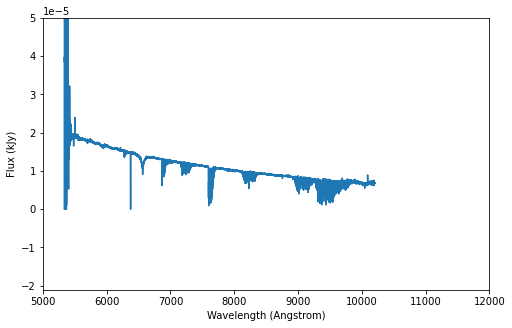

In [32]:
importlib.reload(SYNR)


# GD71 observed spectrum in the visible
# We will not get a specObs for each filter, because not all of them overlap with vis

sp_vis_GD71=SourceSpectrum.from_file("XSHOOTERStandards/GD71_vis_spec.fits",flux_unit='flam')

sp_vis_GD71.plot(left=5000,right=12000,flux_unit="kJy",top=0.00005)


binrange1 = 1000
binrange2 = 30000
GD71_vis_table, GD71vis_ObsDict = \
                                SYNR.get_synphot_table(filters=filters,filter_file=filter_file,
                                                       filters_dir=filters_directory,sp_STD=sp_vis_GD71,
                                                       vega=vega,area=area,filter_plot=False,
                                                        binrange1=binrange1,binrange2=binrange2)

GD71_vis_table

  points: [10862.4 13500.  13500.6 13501.2 13501.8 13543.2 13554.6 13588.8 13590.6
 13591.2 13606.2 13612.8 13615.2 13618.2 13618.8 13620.  13641.  13642.8
 13643.4 13644.  13644.6 13650.  13671.6 13672.2 13674.6 13675.2 13678.2
 13682.4 13696.2 13705.2 13707.  13707.6 13717.2 13718.4 13765.8 13801.8
 13802.4 13803.6 13806.  13806.6 13819.8 13821.6 13822.8 13823.4 13824.
 13824.6 13876.2 13876.8 13877.4 13918.2 13918.8 13919.4 13921.8 13922.4
 13926.6 13945.2 13946.4 13950.6 13951.2 13953.6 13960.2 13962.6 13991.4
 13992.  13997.4 14001.  14001.6 14002.2 14002.8 14003.4 14004.  14010.
 14046.6 14066.4 14067.6 14068.8 14069.4 14091.  14091.6 14513.4 14514.
 14829.6 14830.2 15049.2 15235.2 15235.8 15282.6 15325.8 15389.4 15390.
 15392.4 15649.2 15652.2 15658.2 15659.4 15660.  15829.8 16024.2 16073.4
 16074.  16077.  16126.2 16188.6 16435.8 16439.4 16498.8 16499.4 16688.4
 16689.6 16897.2 16948.2 16951.2 16951.8 17001.6 17443.2 17446.2 17446.8
 17646.6 17647.2 17650.2 17873.4 17874.  1787

 -1.05897484e-06] [synphot.models]


SCORPIO_r wavelengths: [5000. 5520. 5800. 6220. 6500. 6910. 7000.] Angstrom
DisjointError for filter SCORPIO_r
SCORPIO_g wavelengths: [3500. 4000. 4685. 5100. 5520. 6000.] Angstrom
DisjointError for filter SCORPIO_g
SCORPIO_J_no_adc wavelengths: [11000. 11500. 12000. 12500. 13000. 13500. 14000.] Angstrom
SCORPIO_g_no_adc wavelengths: [3500. 4000. 4685. 5100. 5520. 6000.] Angstrom
DisjointError for filter SCORPIO_g_no_adc
SCORPIO_Y_no_adc wavelengths: [ 9000.  9800. 10000. 10400. 10900. 11200. 12000.] Angstrom


SCORPIO_H_no_adc wavelengths: [14000. 15000. 15500. 16300. 17000. 17600. 18000.] Angstrom
SCORPIO_K_no_adc wavelengths: [19000. 20000. 21000. 21750. 22800. 23000.] Angstrom
SCORPIO_z wavelengths: [ 7500.  8180.  8500.  8890.  9220. 10000.] Angstrom
DisjointError for filter SCORPIO_z
SCORPIO_i_no_adc wavelengths: [6000. 6910. 7200. 7550. 7800. 8180. 9000.] Angstrom
DisjointError for filter SCORPIO_i_no_adc
SCORPIO_z_no_adc wavelengths: [ 7500.  8180.  8500.  8890.  9220. 10000.] Angstrom
DisjointError for filter SCORPIO_z_no_adc
SCORPIO_Y wavelengths: [ 9000.  9800. 10000. 10400. 10900. 11200. 12000.] Angstrom
SCORPIO_J wavelengths: [11000. 11500. 12000. 12500. 13000. 13500. 14000.] Angstrom
SCORPIO_K wavelengths: [19000. 20000. 21000. 21750. 22800. 23000.] Angstrom
SCORPIO_i wavelengths: [6000. 6910. 7200. 7550. 7800. 8180. 9000.] Angstrom
DisjointError for filter SCORPIO_i
SCORPIO_r_no_adc wavelengths: [5000. 5520. 5800. 6220. 6500. 6910. 7000.] Angstrom
DisjointError for filter SCORP

,Filter,Counts_s-1,VegaMag,pivot_wl,effective_wl
0,SCORPIO_Y,277609.5 ct,14.183,10660.29 Angstrom,10671.32 Angstrom
1,SCORPIO_Y_no_adc,322324.35 ct,14.183,10660.51 Angstrom,10671.54 Angstrom
2,SCORPIO_J,237460.75 ct,13.989,12295.78 Angstrom,12312.29 Angstrom
3,SCORPIO_J_no_adc,276281.58 ct,13.989,12296.08 Angstrom,12312.61 Angstrom
4,SCORPIO_H,187082.87 ct,13.851,16001.5 Angstrom,16027.18 Angstrom
5,SCORPIO_H_no_adc,219534.91 ct,13.851,16004.92 Angstrom,16030.63 Angstrom
6,SCORPIO_K,57168.46 ct,14.155,21107.32 Angstrom,21127.79 Angstrom
7,SCORPIO_K_no_adc,70307.04 ct,14.151,21128.13 Angstrom,21148.6 Angstrom


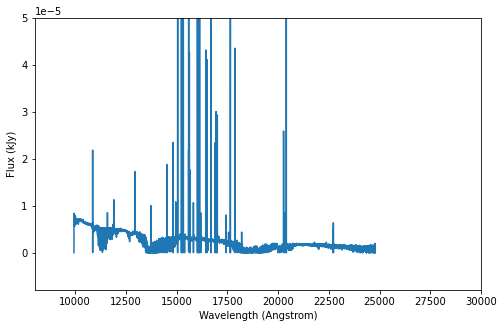

In [33]:
# Do the same thing as the previous cell, but using the observed spectrum in nir

sp_nir_GD71=SourceSpectrum.from_file("XSHOOTERStandards/GD71_nir_spec.fits",flux_unit='flam')

sp_nir_GD71.plot(left=8000,right=30000,flux_unit="kJy",top=0.00005)
GD71_nir_table, GD71nir_ObsDict = \
                                SYNR.get_synphot_table(filters=filters,filter_file=filter_file,
                                                       filters_dir=filters_directory,sp_STD=sp_nir_GD71,
                                                       vega=vega,area=area,filter_plot=False,
                                                        binrange1=binrange1,binrange2=binrange2)

GD71_nir_table

In [34]:
# just combining the two output tables to show the full list of filters
# notice that there are two Y filters because of the overlap between vis and nir

GD71_table = pd.concat((GD71_vis_table,GD71_nir_table)).sort_values(by="effective_wl",ascending=True).reset_index(drop=True)

GD71_table

,Filter,Counts_s-1,VegaMag,pivot_wl,effective_wl
0,SCORPIO_g_no_adc,481207.14 ct,14.899,5552.85 Angstrom,5554.95 Angstrom
1,SCORPIO_g,411897.83 ct,14.889,5552.89 Angstrom,5554.99 Angstrom
2,SCORPIO_r_no_adc,1342484.89 ct,13.361,6042.46 Angstrom,6059.16 Angstrom
3,SCORPIO_r,1152289.84 ct,13.361,6042.63 Angstrom,6059.31 Angstrom
4,SCORPIO_i_no_adc,1174577.54 ct,13.412,7329.47 Angstrom,7358.91 Angstrom
5,SCORPIO_i,1010773.53 ct,13.412,7330.65 Angstrom,7360.09 Angstrom
6,SCORPIO_z,397307.15 ct,13.545,8509.0 Angstrom,8524.1 Angstrom
7,SCORPIO_z_no_adc,460956.69 ct,13.545,8509.2 Angstrom,8524.29 Angstrom
8,SCORPIO_Y_no_adc,202094.07 ct,14.69,9759.71 Angstrom,9763.89 Angstrom
9,SCORPIO_Y,174098.34 ct,14.689,9759.83 Angstrom,9764.02 Angstrom


SCORPIO_r wavelengths: [5000. 5520. 5800. 6220. 6500. 6910. 7000.] Angstrom
SCORPIO_g wavelengths: [3500. 4000. 4685. 5100. 5520. 6000.] Angstrom


SCORPIO_J_no_adc wavelengths: [11000. 11500. 12000. 12500. 13000. 13500. 14000.] Angstrom
DisjointError for filter SCORPIO_J_no_adc
SCORPIO_g_no_adc wavelengths: [3500. 4000. 4685. 5100. 5520. 6000.] Angstrom
SCORPIO_Y_no_adc wavelengths: [ 9000.  9800. 10000. 10400. 10900. 11200. 12000.] Angstrom
SCORPIO_H_no_adc wavelengths: [14000. 15000. 15500. 16300. 17000. 17600. 18000.] Angstrom
DisjointError for filter SCORPIO_H_no_adc
SCORPIO_K_no_adc wavelengths: [19000. 20000. 21000. 21750. 22800. 23000.] Angstrom
DisjointError for filter SCORPIO_K_no_adc
SCORPIO_z wavelengths: [ 7500.  8180.  8500.  8890.  9220. 10000.] Angstrom
SCORPIO_i_no_adc wavelengths: [6000. 6910. 7200. 7550. 7800. 8180. 9000.] Angstrom
SCORPIO_z_no_adc wavelengths: [ 7500.  8180.  8500.  8890.  9220. 10000.] Angstrom
SCORPIO_Y wavelengths: [ 9000.  9800. 10000. 10400. 10900. 11200. 12000.] Angstrom
SCORPIO_J wavelengths: [11000. 11500. 12000. 12500. 13000. 13500. 14000.] Angstrom
DisjointError for filter SCORPIO_J
S

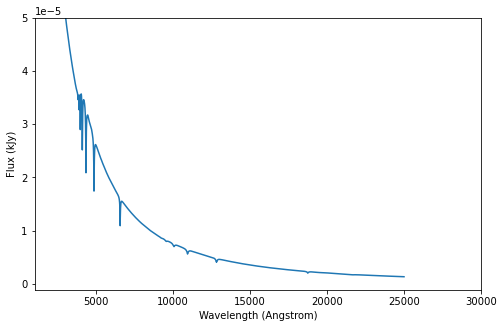

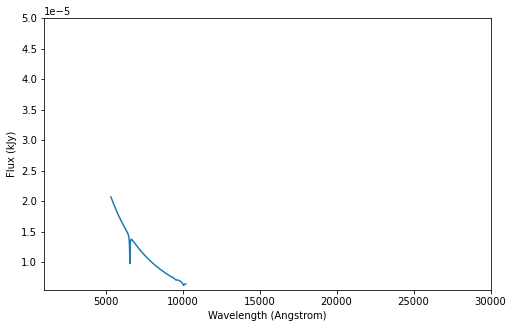

In [35]:
importlib.reload(SYNR)
# now do the procedure for the model spectrum of GD71

sp_mod_GD71 = SourceSpectrum.from_file("XSHOOTERStandards/GD71_mod_spec.fits")

sp_mod_GD71.plot(left=1000,right=30000,flux_unit="kJy",top=0.00005)
#GD71_mod_table, obs_GD71_mod_Filters, obs_vega_mod_Filters = \

wl1 = int(sp_vis_GD71.waverange[0].value)
wl2 = int(sp_vis_GD71.waverange[1].value)
sp_mod_GD71 = SYNR.normalize_model_spectrum(sp_vis_GD71,sp_mod_GD71,bin1=wl1,
                                            bin2=wl2)

sp_mod_GD71.plot(left=1000,right=30000,flux_unit="kJy",top=0.00005)


GD71_mod_table, GD71mod_ObsDict =  SYNR.get_synphot_table(filters=filters,filter_file=filter_file,
                                       filters_dir=filters_directory,sp_STD=sp_mod_GD71,
                                       vega=vega,area=area,filter_plot=False,
                                        binrange1=binrange1,binrange2=binrange2)



In [36]:

GD71_mod_table

,Filter,Counts_s-1,VegaMag,pivot_wl,effective_wl
0,SCORPIO_g_no_adc,489346.32 ct,14.881,5557.31 Angstrom,5559.36 Angstrom
1,SCORPIO_g,418867.88 ct,14.871,5557.35 Angstrom,5559.4 Angstrom
2,SCORPIO_r_no_adc,1504918.06 ct,13.237,5980.43 Angstrom,5989.3 Angstrom
3,SCORPIO_r,1291507.59 ct,13.237,5980.68 Angstrom,5989.55 Angstrom
4,SCORPIO_i_no_adc,1196831.49 ct,13.392,7323.31 Angstrom,7352.31 Angstrom
5,SCORPIO_i,1029931.37 ct,13.392,7324.49 Angstrom,7353.49 Angstrom
6,SCORPIO_z,399162.55 ct,13.54,8515.21 Angstrom,8530.93 Angstrom
7,SCORPIO_z_no_adc,463108.65 ct,13.54,8515.41 Angstrom,8531.13 Angstrom
8,SCORPIO_Y_no_adc,203681.81 ct,14.681,9739.39 Angstrom,9743.61 Angstrom
9,SCORPIO_Y,175460.27 ct,14.681,9739.52 Angstrom,9743.74 Angstrom


/Users/robberto/miniconda3/lib/python3.9/site-packages/astropy/modeling/core.py:3863: RuntimeWarning: invalid value encountered in true_divide
  return binoperator(left, right)


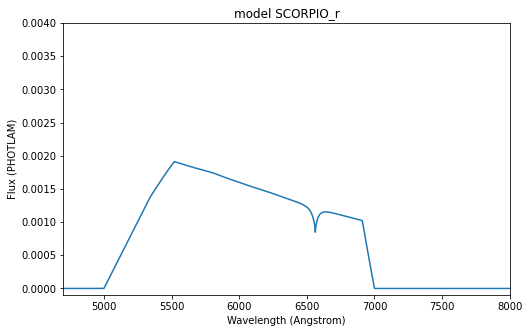

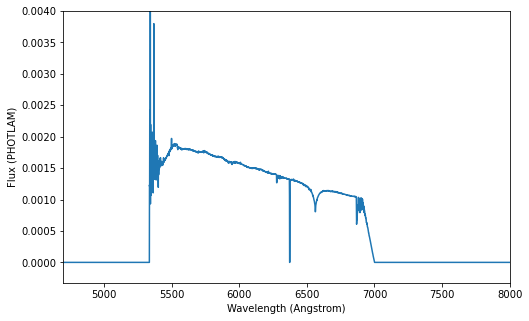

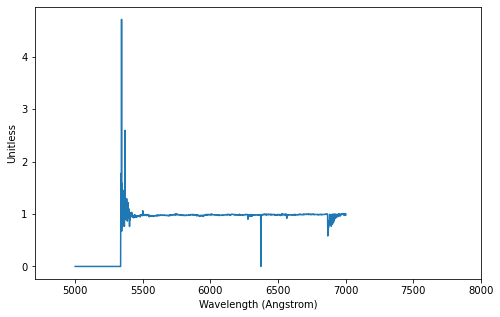

In [37]:
# To compare filters, you have to make sure the index you use actually corresponds to the filter you need
# since they are not in the same order for each set of specObs.

# for r band, both are row 0 in the filter tables (shown in cells above)

filn = "SCORPIO_r"
binset = range(binrange1,binrange2+1)
mod_r_obs = GD71mod_ObsDict[filn].as_spectrum()


mod_r_obs.plot(left=4700,right=8000,title="model {}".format(filn),top=0.004)

GD71vis_ObsDict[filn].plot(left=4700,right=8000,top=0.004)

r = GD71vis_ObsDict[filn].as_spectrum()/mod_r_obs

# plot ratio to see how spectra created from the model star compare to those created with the observation
r.plot(left=4700,right=8000)

from the original file
0.002180258925272782 PHOTLAM

 from converted fluxes
7.708678324433639e-26 FNU
8.1165035787483e-15 FLAM
0.007708678324433638 Jy

 from the rebuilt spectra
7.708678324433639e-26 FNU
8.1165035787483e-15 FLAM
0.007708678324433638 Jy
from the original file
0.044462192806701925 PHOTLAM

 from converted fluxes
1.5740402166145404e-24 FNU
1.6530983510636734e-13 FLAM
0.15740402166145404 Jy

 from the rebuilt spectra
1.5740402166145406e-24 FNU
1.6530983510636734e-13 FLAM
0.15740402166145404 Jy


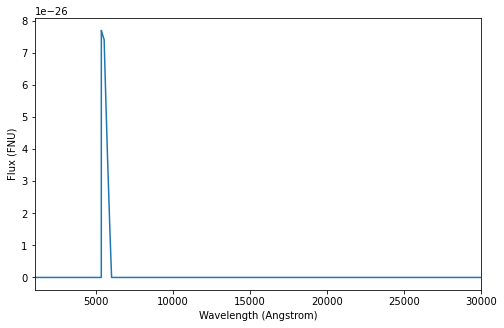

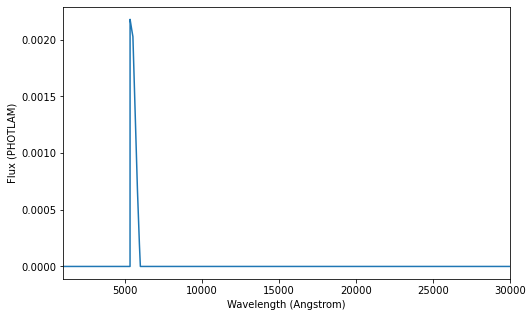

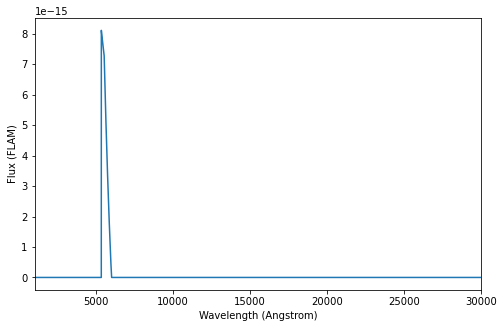

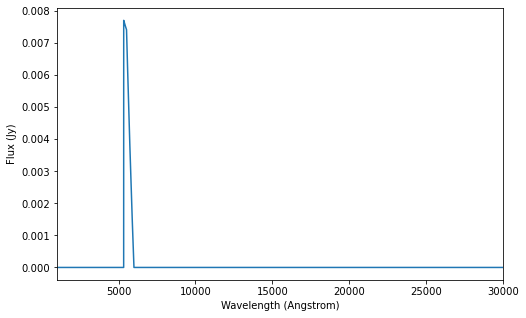

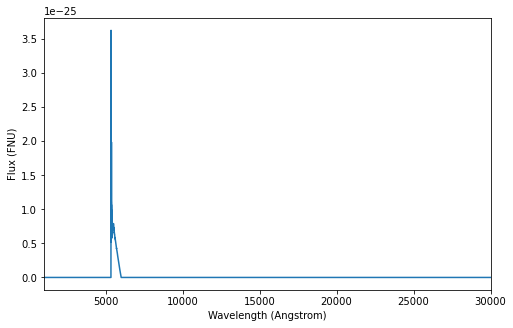

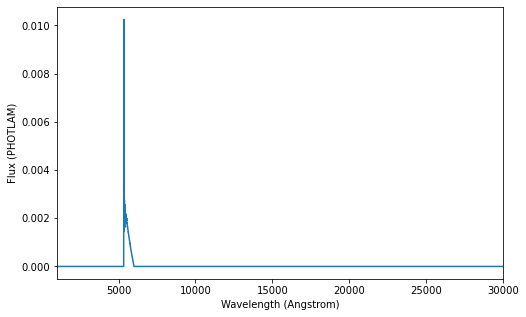

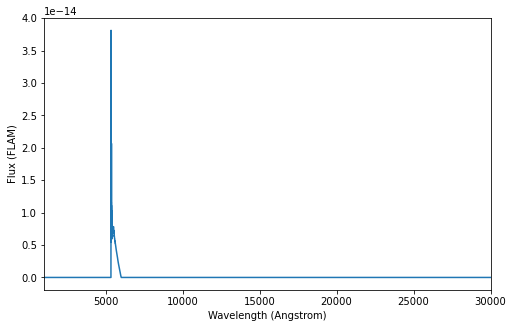

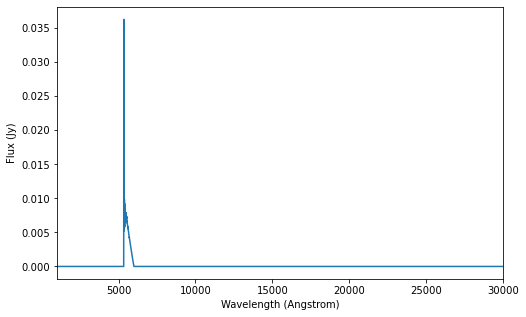

In [38]:
importlib.reload(SYNR)

# call get_synphot_spectra_with_diff_flux_units to convert units

modGD71_r_fnu, modGD71_r_flam, modGD71_r_Jy = \
                            SYNR.get_synphot_spectra_with_diff_flux_units(GD71mod_ObsDict["SCORPIO_g"])

vis_obsGD71_r_fnu, vis_obsGD71_r_flam, vis_obsGD71_r_Jy = \
                            SYNR.get_synphot_spectra_with_diff_flux_units(GD71vis_ObsDict["SCORPIO_g"])




In [39]:
GD71_mod_table.Filter.values

array(['SCORPIO_g_no_adc', 'SCORPIO_g', 'SCORPIO_r_no_adc', 'SCORPIO_r',
       'SCORPIO_i_no_adc', 'SCORPIO_i', 'SCORPIO_z', 'SCORPIO_z_no_adc',
       'SCORPIO_Y_no_adc', 'SCORPIO_Y'], dtype=object)

In [40]:
# Now we can compare the model standard's filter spectra to the observed standard's filter spectra.

# Just grab the spectrum you want from the ObsDict via the filter name.

modObs_g = GD71mod_ObsDict["SCORPIO_g_no_adc"]
visObs_g = GD71vis_ObsDict["SCORPIO_g_no_adc"]
g_obs_div_mod = visObs_g.as_spectrum()/modObs_g.as_spectrum()

modObs_g_no_adc = GD71mod_ObsDict["SCORPIO_g"]
visObs_g_no_adc = GD71vis_ObsDict["SCORPIO_g"]
g_obs_div_mod_no_adc = visObs_g_no_adc.as_spectrum()/modObs_g_no_adc.as_spectrum()


modObs_r = GD71mod_ObsDict["SCORPIO_r_no_adc"]
visObs_r = GD71vis_ObsDict["SCORPIO_r_no_adc"]
r_obs_div_mod = visObs_r.as_spectrum()/modObs_r.as_spectrum()


modObs_J = GD71mod_ObsDict["SCORPIO_J"]
nirObs_J = GD71nir_ObsDict["SCORPIO_J"]
J_obs_div_mod = nirObs_J.as_spectrum()/modObs_J.as_spectrum()

modObs_J_no_adc = GD71mod_ObsDict["SCORPIO_J_no_adc"]
nirObs_J_no_adc = GD71nir_ObsDict["SCORPIO_J_no_adc"]
J_obs_div_mod_no_adc = nirObs_J_no_adc.as_spectrum()/modObs_J_no_adc.as_spectrum()



KeyError: 'SCORPIO_J'

/Users/robberto/miniconda3/lib/python3.9/site-packages/astropy/modeling/core.py:3863: RuntimeWarning: invalid value encountered in true_divide
  return binoperator(left, right)


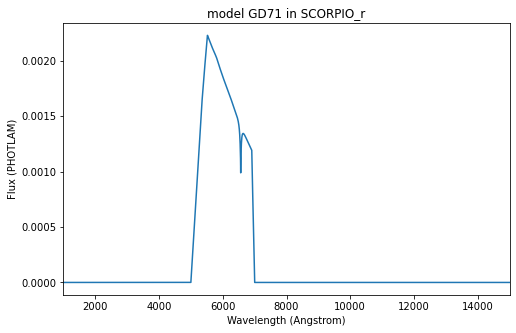

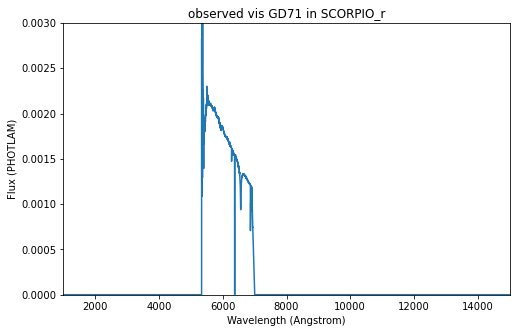

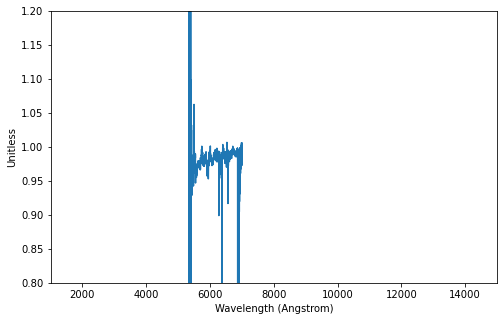

In [41]:
# Let's see what the spectra look like through the K filter

modObs_r.as_spectrum().plot(title="model GD71 in {}".format("SCORPIO_r"),
                           left=1000,right=15000)


visObs_r.as_spectrum().plot(title="observed vis GD71 in {}".format("SCORPIO_r"),
                            left=1000,right=15000,bottom=-0.000001,top=0.003)


r_obs_div_mod.plot(bottom=0.8,top=1.2,left=1000,right=15000)

In [42]:
# Let's see what the spectra look like through the K filter

modObs_J.as_spectrum().plot(title="model GD71 in {}".format("SCORPIO_J"),
                           left=9000,right=15000)


nirObs_J.as_spectrum().plot(title="observed nir GD71 in {}".format("SCORPIO_J"),
                            left=9000,right=15000,bottom=-0.000001,top=0.0003)


J_obs_div_mod.plot(bottom=0.8,top=1.2,left=9000,right=15000)

NameError: name 'modObs_J' is not defined

<IPython.core.display.Javascript object>


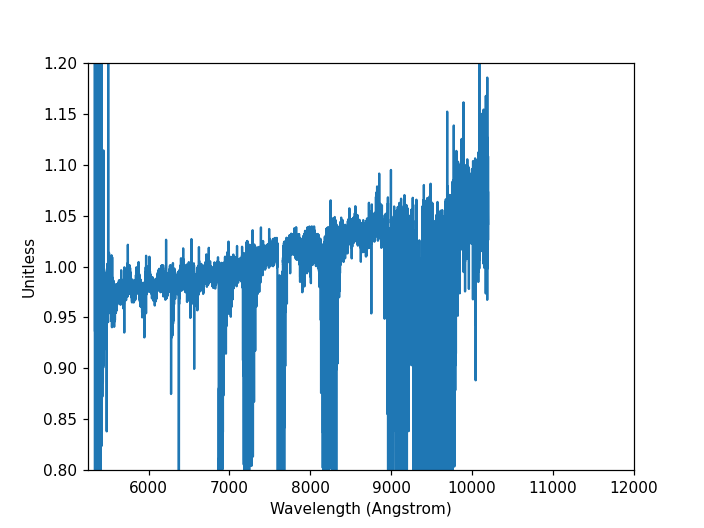

In [43]:
%matplotlib notebook
r_vis = sp_vis_GD71/sp_mod_GD71
r_vis.plot(left=5250,right=12000,bottom=0.8,top=1.2,)

<IPython.core.display.Javascript object>


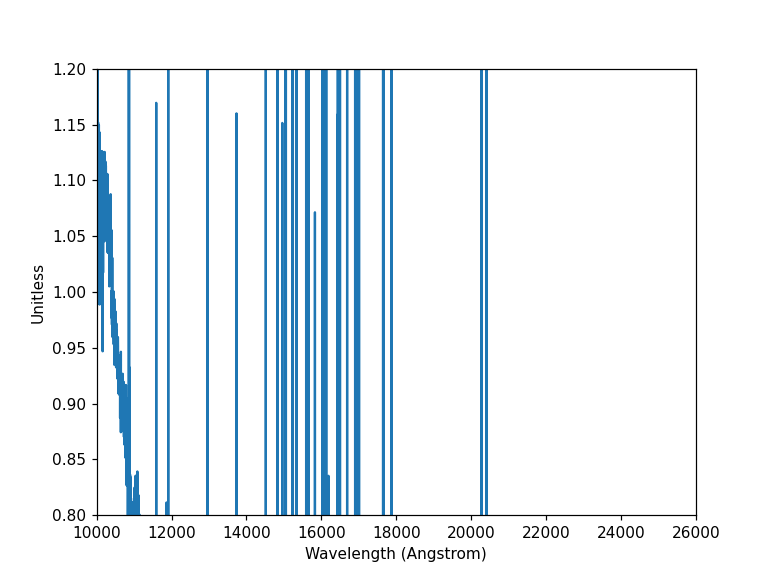

In [44]:
r_nir = sp_nir_GD71/sp_mod_GD71
r_nir.plot(left=10000,right=26000,bottom=0.8,top=1.2,)

In [45]:
from specutils import Spectrum1D

flx_unit = u.erg*u.s**(-1)*u.cm**(-2)*u.angstrom**(-1)


visbin1 = 5300
visbin2 = 10200
vis_binflux = sp_vis_GD71.to_spectrum1d(wavelengths=range(visbin1,visbin2),flux_unit=flx_unit)
modvis_binflux = sp_mod_GD71.to_spectrum1d(wavelengths=range(visbin1,visbin2),flux_unit=flx_unit)

r_vis_flux = vis_binflux.flux/modvis_binflux.flux

med_r_vis_flux = np.median(r_vis_flux)

med_r_vis_flux

<Quantity 0.99967414>

In [46]:
norm_mod = SourceSpectrum(Empirical1D,points=range(visbin1,visbin2)*u.angstrom,
                      lookup_table=modvis_binflux.flux*med_r_vis_flux,keep_neg=True)

<IPython.core.display.Javascript object>


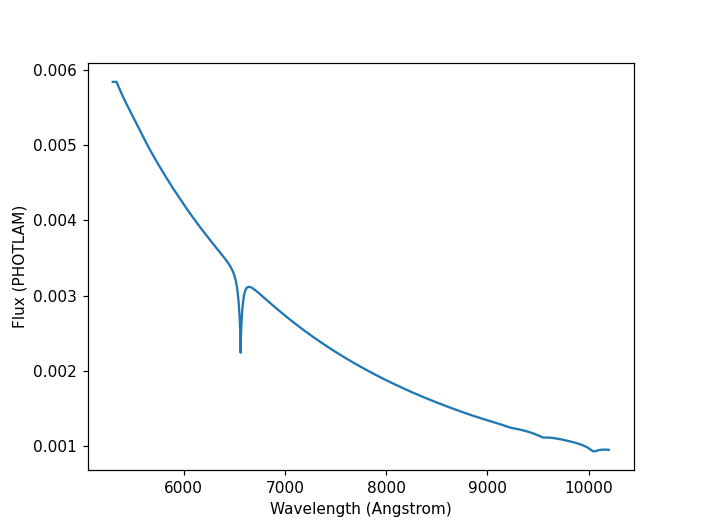

In [47]:
norm_mod.plot()

In [48]:
norm_mod.flux

AttributeError: 'SourceSpectrum' object has no attribute 'flux'

In [49]:
norm_mod